In [3]:
#import packages internal and external
import tests
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from importlib import reload
import pandas as pd
import datasetBuilder
import tools
import scipy
from sklearn.ensemble import HistGradientBoostingClassifier as hgbc
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import RandomForestClassifier as rfc
import sklearn.base
import pickle
import copy
import tests
from sklearn.metrics import roc_auc_score as auc
import os
import plotAndOrderResults
import datasetBuilder

In [4]:
#Set path variables where we want to save created datasets, intermediate outputs, etc
#If you want to run this on your own computer, obviously you should update the path

outputs_path='/Users/jonahpoczobutt/projects/specsim_res/figOutputs'


nist14='/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist14.pkl'
gnps='/Users/jonahpoczobutt/projects/raw_data/db_csvs/gnps.pkl'
mona='/Users/jonahpoczobutt/projects/raw_data/db_csvs/mona_lc.pkl'
metlin='/Users/jonahpoczobutt/projects/raw_data/db_csvs/metlin_experimental.pkl'

#Set the query and target dbs
#these can be different or the same
query = metlin
target = nist14

#This variable toggles whether we do a full run of the notebook, or if we read in variables created in a previous run
fullRun=True

#create directories for results
if fullRun:
    
    os.mkdir(f'{outputs_path}/intermediateOutputs')
    os.mkdir(f'{outputs_path}/intermediateOutputs/fullSearchMatches')
    os.mkdir(f'{outputs_path}/intermediateOutputs/quantileDfs')
    os.mkdir(f'{outputs_path}/intermediateOutputs/modelDatasets')
    os.mkdir(f'{outputs_path}/fig1')
    os.mkdir(f'{outputs_path}/fig2')
    os.mkdir(f'{outputs_path}/fig3')
    os.mkdir(f'{outputs_path}/fig4')


Preprocessing: Creating Target and Matches DFs


In [5]:
if fullRun:

    #This should be replaced with a function to read in all the databases
    query_ = pd.read_pickle(query)
    all_bases = list(set(query_['inchi_base']))

    first_bases = all_bases[:int(len(all_bases)/2)]
    second_bases = all_bases[int(len(all_bases)/2):]

    first_query_ = query_[np.isin(query_['inchi_base'],first_bases)]
    first_query_.reset_index(inplace=True)
    first_query_.to_pickle(f'{outputs_path}/intermediateOutputs/first_query.pkl')
    del(first_query_)

    second_query_ = query_[np.isin(query_['inchi_base'],first_bases)]
    second_query_.reset_index(inplace=True)
    second_query_.to_pickle(f'{outputs_path}/intermediateOutputs/second_query.pkl')
    del(second_query_)
    del(query_)

    
    np.save(f'{outputs_path}/intermediateOutputs/first_bases.npy',first_bases)
    np.save(f'{outputs_path}/intermediateOutputs/second_bases.npy',second_bases)
    del(first_bases)
    del(second_bases)


Figure 1: Global Performance of Individual Metrics/Weighting Schemes

In [6]:
#these are the ppm windows that we want to test
ppm_windows = [10]

#this is the size of the sample we take from the full target
size=5e5

#this is the maximum number of matches we allow for each query, based on the precursor window
max_matches=100

#adduct match
adduct_match=True

#Similarity methods and transformation parameters below. Leave sim methods as None to run all
noise_threshes=[0.01,0.05,0.1]
centroid_tolerance_vals = [0.05, 3]
centroid_tolerance_types=['da']
powers=[0.25,1,3,'ent',None]
sim_methods=None

if fullRun:
    #we will evaluate the performace of the individual metrics on a large sample from the
    #full target dataset. You can set the size below

    #reload queries and target for individual comparison
    query_=pd.read_pickle(query)
    target_=pd.read_pickle(target)

    #shuffle query to ensure random subset
    query_.sample(frac=1)

    for i in ppm_windows:

        matches = datasetBuilder.create_matches_df_new(query_,target_,i,max_matches,size, adduct_match)
        matches.to_pickle(f'{outputs_path}/intermediateOutputs/fullSearchMatches/matches_{i}_ppm.pkl')

        #comparison on large sample
        tests.create_variable_comparisons(
                                noise_threshes=noise_threshes,
                                centroid_threshes=centroid_tolerance_vals,
                                centroid_types=centroid_tolerance_types,
                                powers=powers,
                                sim_methods=sim_methods,
                                matches=matches,
                                outpath = f'{outputs_path}/fig1/{i}_ppm.csv',
                                )

100041 rows created
200009 rows created
300065 rows created
400009 rows created
500013 rows created


Figure 2: Assessing Metric Stability in Smaller Samples

In [7]:
#this is the size of the sample we take from the full target
size=2e3

#this is the number of times we want to take a sample of the above size
trials=100

if fullRun:
    #we will evaluate the performace of the individual metrics on a large sample from the
    #full target dataset. You can set the size below

    #reload target
    query_=pd.read_pickle(query)
    target_=pd.read_pickle(target)

    for i in range(trials):

        os.mkdir(f'{outputs_path}/fig2/{i}')
        
        for j in ppm_windows:

            #create matches after shuffling query
            query_ = query_.sample(frac=1)
            matches = datasetBuilder.create_matches_df_new(query_,target_,j,max_matches,size, adduct_match)

            #comparison on small sample
            tests.create_variable_comparisons(
                                    noise_threshes=noise_threshes,
                                    centroid_threshes=centroid_tolerance_vals,
                                    centroid_types=centroid_tolerance_types,
                                    powers=powers,
                                    sim_methods=sim_methods,
                                    matches=matches,
                                    outpath = f'{outputs_path}/fig2/{i}/{j}_ppm.csv'
                                    )

Figures 1 and 2

Top Metrics for 10_ppm.csv by AUC
      0                               1         2                  3
341  45                       hellinger  0.695784  0.01_0.05_da_None
21   21                      lorentzian  0.693376  0.01_0.05_da_0.25
317  21                      lorentzian  0.690022  0.01_0.05_da_None
45   45                       hellinger  0.688460  0.01_0.05_da_0.25
57   57              max_bhattacharya_2  0.682853  0.01_0.05_da_0.25
313  17  whittaker_index_of_association  0.682330  0.01_0.05_da_None
353  57              max_bhattacharya_2  0.682302  0.01_0.05_da_None
1     1                     max_entropy  0.682293  0.01_0.05_da_0.25
297   1                     max_entropy  0.681990  0.01_0.05_da_None
119  45                       hellinger  0.680898     0.01_0.05_da_1




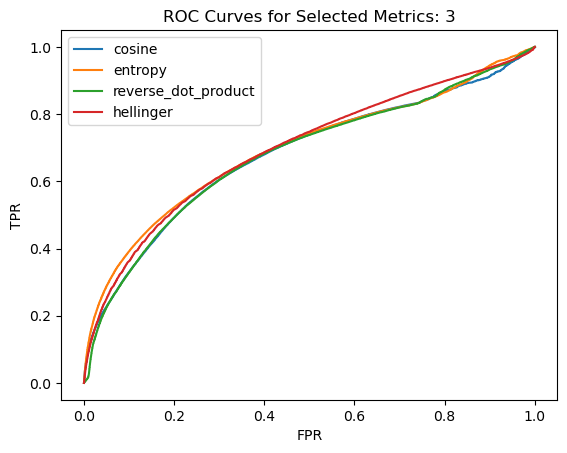

In [8]:
#first, generate tables from full size
plotAndOrderResults.fig1(f'{outputs_path}/fig1','/Users/jonahpoczobutt/projects/specsim_res/figOutputs/intermediateOutputs/fullSearchMatches')


In [9]:
#assess metric stability from small runs
plotAndOrderResults.fig2(f'{outputs_path}/fig2', ppm_windows)

Top Ranks and Means for 10 PPM
Proportion of Time This Metric is Top
                                  index     0
20                          max_entropy  0.01
18                max_squared_euclidean  0.01
17                              entropy  0.01
16                     lorentzian_jonah  0.01
15                       absolute_value  0.01
14                        jensenshannon  0.01
6   probabilistic_symmetric_chi_squared  0.01
19                        max_manhattan  0.01
13                        entropy_jonah  0.02
11       whittaker_index_of_association  0.02


Mean Ranking By Metric
                                  index      0
1        whittaker_index_of_association  40.18
2                           max_entropy  19.92
12                        max_manhattan  49.01
17                        entropy_jonah  22.76
18                              entropy  22.67
19                        jensenshannon  23.16
20  probabilistic_symmetric_chi_squared  22.03
26                     l

Figure 3: Hierarchy of Metric Performance Conditional Distributions


In [ ]:
#we will only consider the default weighting scheme here
#consider all the below metrics
metrics=[]

for i in ppm_windows:

    matches = pd.read_pickle(f'{outputs_path}/intermediateOutputs/fullSearchMatches/{i}_ppm.pkl')
    input_data = datasetBuilder.create_model_dataset(matches, sim_methods = metrics)
    
    plotAndOrderResults.fig3(input_data, test)



Figure 4: Combining Features Into Learned Model

First: Create Train and Test datasets for each ppm window

In [14]:
#Similarity methods and transformation parameters below. Leave sim methods as None to run all
noise_threshes=[0.01,0.05,0.1]
centroid_tolerance_vals = [0.05,3]
centroid_tolerance_types=['da', 'ppm']
powers=[0.25,1,3,'ent',None]
sim_methods=[]

train_size=1.1e6
test_size=5e5

max_matches=50

target_=pd.read_pickle(target)

for i in ppm_windows:

    #read in first bases and shuffle order
    query_train = pd.read_pickle(f'{outputs_path}/intermediateOutputs/first_query.pkl')
    query_train=query_train.sample(frac=1)

    #create matches for model to train on
    matches = datasetBuilder.create_matches_df_new(query_train,target_,i,max_matches,train_size, adduct_match)
    del(query_train)

    train = datasetBuilder.create_model_dataset(
                                                matches, 
                                                sim_methods, 
                                                noise_threshes, 
                                                centroid_tolerance_vals, 
                                                centroid_tolerance_types,
                                                powers
                                                )
    
    train.to_pickle(f'{outputs_path}/intermediateOutpus/model_data/train_{i}_ppm.pkl')
    del(matches)
    del(train)

    #read in test queries and shuffle order
    query_test = pd.read_pickle(f'{outputs_path}/intermediateOutputs/second_query.pkl')
    query_test=query_test.sample(frac=1)

    #create matches for model to train on
    matches = datasetBuilder.create_matches_df_new(query_test,target_,i,max_matches,test_size, adduct_match)

    del(query_test)

    test = datasetBuilder.create_model_dataset(
                                                matches, 
                                                sim_methods, 
                                                noise_threshes, 
                                                centroid_tolerance_vals, 
                                                centroid_tolerance_types,
                                                powers
                                                )
    
    test.to_pickle(f'{outputs_path}/intermediateOutpus/modelDatasets/test_{i}_ppm.pkl')
    matches.to_pickle(f'{outputs_path}/intermediateOutpus/modelDatasets/test_{i}_ppm_matches.pkl')
    del(matches)
    del(test)

100024 rows created
200004 rows created
300018 rows created
400012 rows created


KeyboardInterrupt: 

Then, create the indices we want to test (different features for model)

In [ ]:
indices=dict()

noise_threshes=[True,True,True]
centroid_tolerance_values=[True,True]
powers=[True,True,True,True,True]
spec_features=[True,True, True, True, True, True, True, True]#8
sim_methods=[True,True,True,True]#7

indices['all'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_vals,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      True,
                                                      True,
                                                      True
                                                    )

indices['all_but_nonspec'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_vals,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      True,
                                                      False,
                                                      True
                                                    )

indices['nonspec_only']=list(range(9))
indices['nonspec_no_precursor']=[2,3,4,5,6]


sim_methods=[False, False, False, False]#7
indices['no_sims'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_vals,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      False,
                                                      True,
                                                      True
                                                    )

noise_threshes=[True,True,True]
centroid_tolerance_values=[True,True]
powers=[True,True,True,True,True]
spec_features=[False for i in range(8)]#8
sim_methods=[True,True,True,True]#7

indices['sims_only'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_vals,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      False,
                                                      True,
                                                      False,
                                                    )


noise_threshes=[True,False,True]
centroid_tolerance_values=[True,False]
powers=[True,False,True,False,True]
spec_features=[True for i in range(8)]#8
sim_methods=[True,True,False, False]#7

indices['small_model'] = datasetBuilder.generate_keep_indices(noise_threshes,
                                                      centroid_tolerance_vals,
                                                      powers,
                                                      spec_features,
                                                      sim_methods,
                                                      False,
                                                      True,
                                                      True,
                                                    )


In [ ]:
#import train, val and test
train = pd.read_pickle(f'{outputs_path}/intermediateOutpus/modelDatasets/train_{i}_ppm.pkl')
test = pd.read_pickle(f'{outputs_path}/intermediateOutpus/modelDatasets/test_{i}_ppm.pkl')
val=train[:int(1e5)]
train=train[int(1e5):]

#hyperparam specifications for models
models = [
        hgbc(),
        hgbc(learning_rate=0.01),
        hgbc(learning_rate=0.5),
        hgbc(max_iter=200),
        hgbc(learning_rate=0.01, max_iter=200),
        hgbc(learning_rate=0.5, max_iter=200),
        hgbc(min_samples_leaf=10),
        hgbc(learning_rate=0.01,min_samples_leaf=10),
        hgbc(learning_rate=0.5,min_samples_leaf=10),
        hgbc(max_iter=200,min_samples_leaf=10),
        hgbc(learning_rate=0.01, max_iter=200,min_samples_leaf=10),
        hgbc(learning_rate=0.5, max_iter=200,min_samples_leaf=10),
        ]

results_by_subset = tests.best_models_by_subset(indices, [int(1e6)], models, train, val, test)

del(train)
del(val)